miniGAP (in repository)  
currently compartmentalizing this into multiple notebooks

In [1]:
import sys
sys.path.append('../code')
from Molecular_Dynamics import generate_md_traj, make_diatomic
from Generate_Descriptors import get_dscribe_descriptors

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tfp.math.psd_kernels
from itertools import islice
from  tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
from ase.io import read

In [2]:
# I previously used these imports and I'm keeping them here for convenience
# until I'm ready to move the training out of the notebook
# just in case I need them

if False:
    from miniGAP_functions import LearnEnergyFromSoap, LearnFromSoap

    import matplotlib
    import numpy.random as rand
    import time
    from ase import Atoms
    from ase.calculators.emt import EMT
    from ase.calculators.lj import LennardJones
    from ase.calculators.morse import MorsePotential
    #from xtb.ase.calculator import XTB
    from ase.optimize import BFGS
    from ase.optimize import MDMin
    from ase.io import read
    from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
    from ase.md.verlet import VelocityVerlet
    from ase.md.nvtberendsen import NVTBerendsen
    from ase import units
    from dscribe.descriptors import SOAP
    from numpy import polyfit
    from numpy import poly1d
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
    import tensorflow as tf
    import tensorflow_probability as tfp
    from  tensorflow_probability import distributions as tfd
    import gpflow.optimizers as gpopts
    import numpy.random as rand
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.metrics.pairwise import rbf_kernel
    tfk = tfp.math.psd_kernels
    from sklearn.metrics import mean_squared_error
    from matplotlib import animation
    from IPython.display import HTML
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import LogFormatterMathtext
    from mpl_toolkits import mplot3d
    from matplotlib import cm
    from os.path import join

In [3]:
# some basic helper functions

def PrintNoScientificNotation(*x):
    np.set_printoptions(suppress=True) # Do not print in scientific notation
    print(*x)
    np.set_printoptions(suppress=False)
       
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

In [4]:
# These plotting settings make graphs easier to read
# This is a very clunky way to do this so I want to move this soon, but haven't had much of a chance

SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIG_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

---

# Current Training (As of 9/21)
### Broken into a bunch of steps with comments

---

## Prep work

Define all settings now

In [16]:
# I only use these settings if I am training on diatomic structures
use_diatomics = False
if use_diatomics:
    my_element = "O"
    my_temp=300
    my_calc = "EMT"
    my_md_seed = 1

# Number of structures    
my_n = 100

# SOAP parameters
get_local_descriptors = True
my_rcut = 3.2
my_nmax = 5
my_lmax = 5
attach_SOAP_center = True
is_periodic = False

# Training parameters
use_forces = True
split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9
shuffle_seed = 1
batch_size_max = 100
learn_rate = 0.025
n_epochs_max = 40
print_frequency = 10


Pick which structures to train

In [6]:
# Diatomic molecule with evenly spaced bond lengths
# AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.6,1.8, my_n)]

# Diatomic molecule in MD trajectory
# AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)

# 2000 distorted propanols (librascal structures)
#   Forces included
AtomsList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(my_n))

# 10000 graphenes from Alvaro
#   Forces included
# AtomsList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))

# 6095 isomers of C7O2H10 (subset of QM9)
#   No forces
# AtomsList = read("../data/C7O2H10.extxyz.gz", ":{}".format(my_n))

Parse data from dataset

In [7]:
PosList =  np.array([atoms.positions for atoms in AtomsList])

EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64)

if use_forces:
    ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)
else:
    ForceList = ["Not Using Forces"] * my_n

Generate SOAP descriptors

In [8]:
dscribe_output = get_dscribe_descriptors(
                                        AtomsList,
                                        species=np.unique(AtomsList[0].get_chemical_symbols()), 
                                        attach=attach_SOAP_center, 
                                        is_periodic = is_periodic,
                                        is_global= not get_local_descriptors,
                                        return_derivatives= use_forces, 
                                        nmax=my_nmax, 
                                        lmax=my_lmax,
                                        rcut=my_rcut
                                        )

if use_forces:
    SoapDerivativeList, SoapList = dscribe_output
else:
    SoapList = dscribe_output
    SoapDerivativeList = ["Not Using Forces"] * my_n

---

## Now the training starts

Split all data into training and test sets.

Test sets will not be viewed until training is done

In [9]:
split_data = train_test_split(SoapList, 
                              SoapDerivativeList, 
                              EnergyList, 
                              ForceList, 
                              PosList, 
                              range(len(SoapList)), 
                              random_state=split_seed, 
                              test_size=(1-training_frac))

train_sps, test_sps, train_dsp_dx, test_dsp_dx, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data

Scale soaps and energies separately to have zero mean and unit variance.

Divide the derivatives by the same scale factor but don't subtract the mean

In [10]:

train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
soap_scaler = StandardScaler().fit(train_sps)
train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
if use_forces:
    test_dsp_dx /= soap_scaler.scale_[None, None, None, None, :]
    train_dsp_dx /= soap_scaler.scale_[None, None, None, None, :]


ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
if use_forces:
    train_frcs = train_frcs / ens_scaler.scale_
    test_frcs = test_frcs / ens_scaler.scale_

# Should the variance be calculated before the rescaling?
ens_var = train_ens.var()
if use_forces:
    frcs_var = train_frcs.var()

Convert data to tensorflow tensors where necessary

In [11]:
train_sps = tf.constant(train_sps, dtype=np.float64)
train_ens = tf.constant(train_ens, dtype=np.float64)
test_sps = tf.constant(test_sps, dtype=np.float64)

if use_forces:
    train_frcs = tf.constant(train_frcs, dtype=np.float64)
else:
    train_frcs = tf.constant(train_frcs)    

Initialize kernels and model hyperparameters

In [12]:
noise_init = 1e-5
amp_init = 0.1
# The following line tries to control for the size and natural spread of the data
len_init = 10 * train_sps.shape[1] * train_sps.shape[2]/np.sum(soap_scaler.scale_ )

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

obs_noise = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise")
amplitude = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude")
len_scale = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale")
kernel = tfk.ExponentiatedQuadratic(amplitude=amplitude, length_scale=len_scale, name="kernel", feature_ndims=2)
trainable_variables = [var.variables[0] for var in [amplitude, len_scale, obs_noise]]


Define a few things used in training loop

* loss/error function
* optimizer

In [13]:
# Note: I still need to add the Tikhonov regularization term for loss to make the mse equivalent to negative log likelihood

@tf.function(autograph=False, experimental_compile=False)
def mse(y_predict, y_true):
    return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

@tf.function(autograph=False, experimental_compile=False)
def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
    mse1 = mse(y1_predict, y1_true)
    mse2 = mse(y2_predict, y2_true)*3
    return mse1 * weight1 + mse2 * weight2

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

Perform training loop

In [14]:
for j in range(n_epochs_max):
    if not j % print_frequency:
        print("Epoch {}".format(j+1))
        print(" ".join(["{} = {:.2e} ".format(var.name, np.exp(var.numpy())) for var in trainable_variables]))
    
    # Split training data into training and validation sets
    # Now validation set acts as temporary est set
    # train_test_split and tensorflow tensors don't get along so I temporarily convert them back to numpy arrays
    split_data_j = train_test_split(train_sps.numpy(), 
                                    train_ens.numpy(), 
                                    train_dsp_dx, 
                                    train_frcs.numpy(), 
                                    random_state =valid_split_seed+j,
                                    test_size=(1-valid_fract))
    train_sps_j, valid_sp_j, train_ens_j, valid_ens_j, train_dsp_dx_j, valid_dsp_dx_j, train_frcs_j, valid_frcs_j = split_data_j
    
    # Convert to tensorflow constant tensors
    train_sps_j = tf.constant(train_sps_j, dtype=np.float64)
    train_ens_j = tf.constant(train_ens_j, dtype=np.float64)
    valid_sp_j = tf.constant(valid_sp_j, dtype=np.float64)
    valid_ens_j = tf.constant(valid_ens_j, dtype=np.float64)
    
    if use_forces:
        train_dsp_dx_j = tf.constant(train_dsp_dx_j, dtype=np.float64)
        train_frcs_j = tf.constant(train_frcs_j, dtype=np.float64)    
        valid_dsp_dx_j = tf.constant(valid_dsp_dx_j, dtype=np.float64)
        valid_frcs_j = tf.constant(valid_frcs_j, dtype=np.float64)        
    
    
    # Batch data if  training set is larger than batch_size_max
    if len(train_sps_j) < batch_size_max:
        iterations_per_epoch = 1
        batch_size = len(train_sps_j)
    else:
        iterations_per_epoch = int(np.ceil(len(train_sps_j)/batch_size_max))
        batch_size = int(np.ceil(len(train_sps_j)/iterations_per_epoch))

    batches_j = (
        tf.data.Dataset.from_tensor_slices((train_sps_j, train_ens_j, train_dsp_dx_j, train_frcs_j)) 
        .shuffle(buffer_size=len(train_sps_j), seed=shuffle_seed) 
        .repeat(count=None)
        .batch(batch_size)
    )
    
    
    for i, (index_points_j_i, train_ens_j_i, train_dsp_dx_j_i, train_frcs_j_i) in enumerate(islice(batches_j, iterations_per_epoch)):
        with tf.GradientTape() as tape:
            with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
                tape_sps.watch(valid_sp_j)    
                gprm_j_i = tfd.GaussianProcessRegressionModel(
                    kernel = kernel,
                    index_points = valid_sp_j,
                    observation_index_points = index_points_j_i,
                    observations = train_ens_j_i,
                    observation_noise_variance = obs_noise)
                predict_ens_j_i = gprm_j_i.sample()
                
            if use_forces:
                predict_d_ens_j_i = tape_sps.gradient(predict_ens_j_i, valid_sp_j)
                predict_frcs_j_i = -1*np.einsum('imjkl,iml->ijk', valid_dsp_dx_j, predict_d_ens_j_i)
                mse_j_i = mse_2factor(predict_ens_j_i, valid_ens_j, 1/ens_var,
                                        predict_frcs_j_i, valid_frcs_j, 1/frcs_var)
            else:
                mse_j_i = mse(predict_ens_j_i, valid_ens_j)
                
        grads = tape.gradient(mse_j_i, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))


with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
    tape_sps.watch(test_sps)    

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=test_sps,
        observation_index_points=train_sps,
        observations=train_ens,
        observation_noise_variance=obs_noise)

    predict_ens = gprm.mean()


test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
predict_ens_rescaled = ens_scaler.inverse_transform(predict_ens)

if use_forces:
    predict_d_ens = tape_sps.gradient(predict_ens, test_sps)
    predict_frcs = -1*np.einsum('imjkl,iml->ijk', test_dsp_dx, predict_d_ens)
    
    test_frcs_rescaled = test_frcs * ens_scaler.scale_
    predict_frcs_rescaled = predict_frcs * ens_scaler.scale_


Epoch 1
amplitude:0 = 1.00e-01  len_scale:0 = 2.88e+03  noise:0 = 1.00e-05 
Epoch 11
amplitude:0 = 1.04e-01  len_scale:0 = 2.77e+03  noise:0 = 9.63e-06 
Epoch 21
amplitude:0 = 1.22e-01  len_scale:0 = 2.36e+03  noise:0 = 8.22e-06 
Epoch 31
amplitude:0 = 1.43e-01  len_scale:0 = 2.01e+03  noise:0 = 7.02e-06 


Plot results

Text(0.5, 1.0, 'Error Histogram for Energy Predictions')

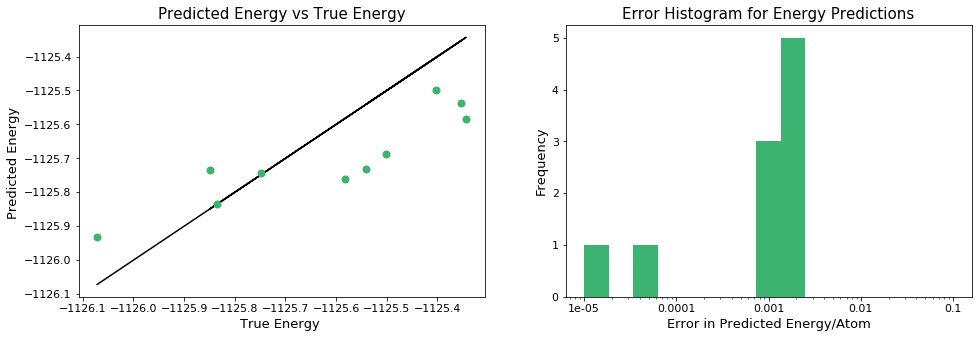

In [15]:
fig, axs = plt.subplots(figsize=(16,5), ncols=2)

axs[0].set_title("Predicted Energy vs True Energy")
axs[0].set_xlabel("True Energy ")
axs[0].set_ylabel("Predicted Energy ")
axs[0].plot(test_ens_rescaled, test_ens_rescaled, "-", c="k")
axs[0].plot(test_ens_rescaled, predict_ens_rescaled ,"o", c="mediumseagreen", ms=7)

errors = abs(predict_ens_rescaled-test_ens_rescaled)/len(AtomsList[0])
logbins = np.logspace(-5,-1,16)
logticklabels = np.logspace(-5,-1,5)
axs[1].hist(errors, bins=logbins, color="mediumseagreen")
axs[1].set_xscale('log')
axs[1].set_xticks(logticklabels)
axs[1].set_xticklabels(logticklabels)
axs[1].set_xlabel("Error in Predicted Energy/Atom")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Error Histogram for Energy Predictions")

---

# Old training code below

## <span style="color:red">Warning: Here be clutter!</span>
## <span style="color:red">(And confusing variable names!)</span>


---

### Energies no forces


In [362]:
# Testing this with the C7O2H10 database (which contains 6095 structures)

my_n = ""
my_element="O"
my_temp=300
my_n_train = 70
my_n_test = 30
my_n = my_n_train + my_n_test
my_calc = "EMT"
my_md_seed = 1

from Molecular_Dynamics import make_diatomic
AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.8,1.0,my_n)]
#AtomsList = read("../data/distorted_propanol.extxyz.gz", f":{my_n}")
#AtomsList = read("../data/ManyGraphenes_unzipped.extxyz", f":{my_n}")
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64)
# EnergyList = np.array([atom.info["energy"] for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
#SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=["C", "H", "O"], is_global=False, return_derivatives=True, nmax=5,lmax=5, is_periodic=True)
SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), is_global=False, return_derivatives=False, nmax=5, lmax=5, is_periodic=False)

# set

In [738]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)
from sklearn.preprocessing import StandardScaler

collapsable=True

split_seed = 1
valid_split_seed = 1
training_frac = 0.9#my_n_train/my_n#0.9
valid_fract = 0.9

train_sps, test_sps, train_ens, test_ens,  train_pos, test_pos = train_test_split(SoapList, EnergyList, PosList,  random_state=split_seed, test_size=(1-training_frac))

# scaling
# ----------------------------------------------------------------------------------------
if collapsable:
    # Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
    # both descriptors and their derivatives on training and test sets.
    # # pass with_mean=False to avoid breaking sparsity structure of data
    rescale_method = 1
    if rescale_method == 1:
        train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
        soap_scaler = StandardScaler().fit(train_sps)
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
        train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
    elif rescale_method == 2:
        train_sps, test_sps = train_sps.reshape(train_sps.shape[0], -1), test_sps.reshape(test_sps.shape[0], -1)
        soap_scaler = StandardScaler().fit(train_sps)
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
        train_sps, test_sps = train_sps.reshape(len(train_ens), SoapList.shape[1], -1), test_sps.reshape(len(test_ens), SoapList.shape[1], -1)

    # rescale energies
    ens_scaler = StandardScaler().fit(train_ens[:,None])
    train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
# ----------------------------------------------------------------------------------------

observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.025
n_epochs = 10; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
if collapsable:
    noise_init = 1e-5; amp_init = 0.1; len_init = 100#42
    constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
    # nll (old approach)
    obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
    amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
    len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
    kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=2)#SoapList.shape[1])
    trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
    # mostly mse, my custom approach
    # allows for forces to be considered during training
    obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
    amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
    len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
    kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=2)#SoapList.shape[1])
    trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)

        return -gp.log_prob(observations)

    # Define mini-batch data iterator
    batches_nll = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )
    #

    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    for j in range(n_epochs):
        if not j % 3:
            print("Old learning, epoch {}".format(j))

        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        predict_ens_nll = gprm_nll.mean()
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if collapsable:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 0
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
    
    error_history = []
    for j in range(n_epochs_custom):
        if not j % 5:
            print("Custom learning, epoch {}".format(j))

        split_data_j = train_test_split(train_sps, train_ens, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)


        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        error_j = 0
        for i, (index_points_j_i, ens_observations_j_i) in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                error_custom_j_i = mse(predict_ens_j_i, heldout_ens_observations_j)
                error_j += error_custom_j_i


            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
        interpretable_error_j = np.sqrt(error_j/iterations_per_epoch_custom)
        error_history.append(interpretable_error_j)
        print("Error {} = {:.2f}".format(j, interpretable_error_j))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()
    
    test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
    
    predict_ens_custom_rescaled = ens_scaler.inverse_transform(predict_ens_custom)
        
    performance_Graphene_by_n[my_n_train] = np.max(np.abs(ens_scaler.inverse_transform(test_ens) - ens_scaler.inverse_transform(predict_ens_custom)))
# ----------------------------------------------------------------------------------------


Custom learning, epoch 0
Error 0 = 0.06
Error 1 = 0.05
Error 2 = 0.03
Error 3 = 0.05
Error 4 = 0.05
Custom learning, epoch 5
Error 5 = 0.04
Error 6 = 0.03
Error 7 = 0.03
Error 8 = 0.02
Error 9 = 0.02


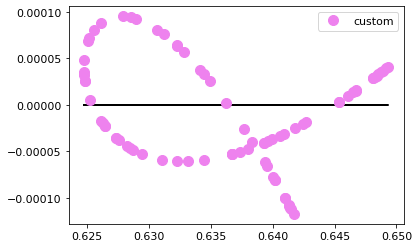

In [372]:
plot_custom = True; plot_nll = False
plt.plot(test_ens_rescaled, np.zeros(len(test_ens)), "-", c="k")
if plot_custom:
    plt.plot(test_ens_rescaled, predict_ens_custom_rescaled-test_ens_rescaled ,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens_rescaled, predict_ens_nll_rescaled-test_ens_rescaled ,"o", label="nll", c="lime", ms=5)
plt.legend()


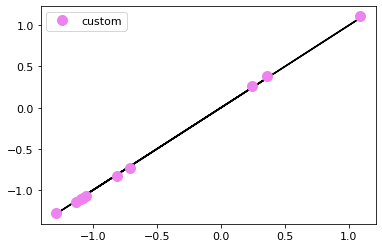

In [741]:
plot_custom = True; plot_nll = False
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

---

### Forces and energies

In [472]:
# Collect input data for soap->energy/forces learning model without looping
# Unlike above (in the Plottable_Model_Errors cell) I am collecting forces here as well



# SOAP parameters


#from Molecular_Dynamics import make_diatomic
#AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.6,1.8, my_n)]
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
#AtomsList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))
AtomsList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(my_n))
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
#AveragePosition = np.mean(PosList.reshape(-1, PosList.shape[-1]), axis = 0)
#SoapCenterPositions = AveragePosition[None, :].repeat(PosList.shape[0], axis=0)[:,None,:]
#SoapCenterPositions = np.array([AveragePosition, [0,0,0]])[None,:].repeat(PosList.shape[0], axis=0)

EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)#[:,1] # only get force of one atom while we are doing global soap
SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), attach=attach_SOAP_center, is_periodic = is_periodic,
                                                       is_global= not get_local_descriptors, return_derivatives=True, nmax=my_nmax, lmax=my_lmax)#, positions = SoapCenterPositions)


In [473]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data


train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
soap_scaler = StandardScaler().fit(train_sps)
train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
test_d_sps /= soap_scaler.scale_[None, None, None, None, :]
train_d_sps /= soap_scaler.scale_[None, None, None, None, :]


ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.025
n_epochs_max = 10; n_epochs_max_nll = n_epochs_max; n_epochs_max_custom = n_epochs_max
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e-5; amp_init = 0.1; len_init = 100 * train_sps.shape[1] * train_sps.shape[2]/np.sum(soap_scaler.scale_ )
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=2)
trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

if False:
    for j in range(n_epochs_max):

        loss_nll_j = 0
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
                loss_nll_j += loss_nll_i
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))
        if not j % 4:
            print("Old learning, epoch {} loss: {:10.0f}".format(j, loss_nll_j))
            print([(v.name, 2.71828**v.numpy()) for v in trainable_variables_nll])

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        print(index_points.shape)
        print(observation_index_points.shape)
        print(ens_observations.shape)
        predict_ens_nll = gprm_nll.mean()

    predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
    #print(predict_d_ens_nll[:1])
    #predict_d_ens_nll = predict_d_ens_nll[:,0,:]
    #print(predict_d_ens_nll[:1])

    print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
    print("test_d_sps.shape = ", test_d_sps.shape )
    print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
    print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
    predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
    print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

    # predict_d_ens_nll.shape = (75, 2, 18)
    # test_d_sps.shape =  (75, 2, 2, 3, 18)
    #     print("test_d_sps", test_d_sps)
    #     print("predict_d_ens_nll", predict_d_ens_nll)
    #     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
    # ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if True:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
        #print("mse1 = ", mse1 / weight1)
        mse2 = mse(y2_predict, y2_true)*3
        #mse2 = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.squared_difference(y_predict, y_true), axis = 2))
        #print("mse2 = ", mse2 / weight2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    
    # ----------------- see if this works -----------------
    print(observation_index_points.shape)
    print(ens_observations.shape)
    loss_custom_nll(observation_index_points, ens_observations)
    # 
    

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_max_custom_nll = 0
    for j in range(n_epochs_max_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_max_custom):
        
        if not j % 1:
            print("Custom learning, epoch {}".format(j+1))
            print([" {} = {:.2e} ".format(var.name, np.exp(var.numpy())) for var in trainable_variables_custom])

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,iml->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)


            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,iml->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap

    test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
    predict_ens_custom_rescaled = ens_scaler.inverse_transform(predict_ens_custom)
# -------------------------------------------------------------------



(1800, 10, 2700)
(1800,)
Custom learning, epoch 1
[' amplitude_custom:0 = 1.00e-01 ', ' len_scale_custom:0 = 3.01e+03 ', ' noise_custom:0 = 1.00e-05 ']
Custom learning, epoch 2
[' amplitude_custom:0 = 1.43e-01 ', ' len_scale_custom:0 = 2.10e+03 ', ' noise_custom:0 = 7.00e-06 ']
Custom learning, epoch 3
[' amplitude_custom:0 = 1.73e-01 ', ' len_scale_custom:0 = 1.74e+03 ', ' noise_custom:0 = 5.81e-06 ']
Custom learning, epoch 4
[' amplitude_custom:0 = 1.98e-01 ', ' len_scale_custom:0 = 1.51e+03 ', ' noise_custom:0 = 5.11e-06 ']
Custom learning, epoch 5
[' amplitude_custom:0 = 2.33e-01 ', ' len_scale_custom:0 = 1.27e+03 ', ' noise_custom:0 = 4.38e-06 ']
Custom learning, epoch 6
[' amplitude_custom:0 = 2.65e-01 ', ' len_scale_custom:0 = 1.10e+03 ', ' noise_custom:0 = 3.89e-06 ']
Custom learning, epoch 7
[' amplitude_custom:0 = 2.86e-01 ', ' len_scale_custom:0 = 1.00e+03 ', ' noise_custom:0 = 3.63e-06 ']
Custom learning, epoch 8
[' amplitude_custom:0 = 3.00e-01 ', ' len_scale_custom:0 = 9.

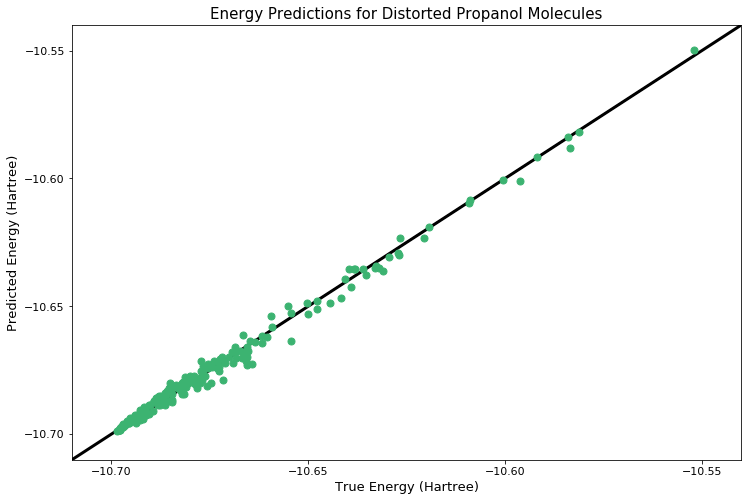

In [484]:
fig, ax = plt.subplots(figsize=(12,8))


import matplotlib
matplotlib.rc('font', size=20)
ticks = [-10.50, -10.55, -10.60, -10.65, -10.70, -10.75]
plt.plot(ticks, ticks, c="k", lw=3)
lower_lim = -10.71
upper_lim = -10.54
plt.xticks(ticks); plt.xlim(lower_lim, upper_lim)
plt.yticks(ticks); plt.ylim(lower_lim, upper_lim)
plt.xlabel("True Energy (Hartree)")
plt.ylabel("Predicted Energy (Hartree)")
plt.title("Energy Predictions for Distorted Propanol Molecules")

plot_custom = True; plot_nll = False
plt.plot(test_ens_rescaled/27.2114, test_ens_rescaled/27.2114, "-", c="k")
if plot_custom:
    plt.plot(test_ens_rescaled/27.2114, predict_ens_custom_rescaled/27.2114 ,"o", label="custom", c="mediumseagreen", ms=7)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll ,"o", label="nll", c="lime", ms=5)
#plt.legend()

Text(0.5, 1.0, 'Error Histogram for Energy Predictions for Distorted Propanol Molecules')

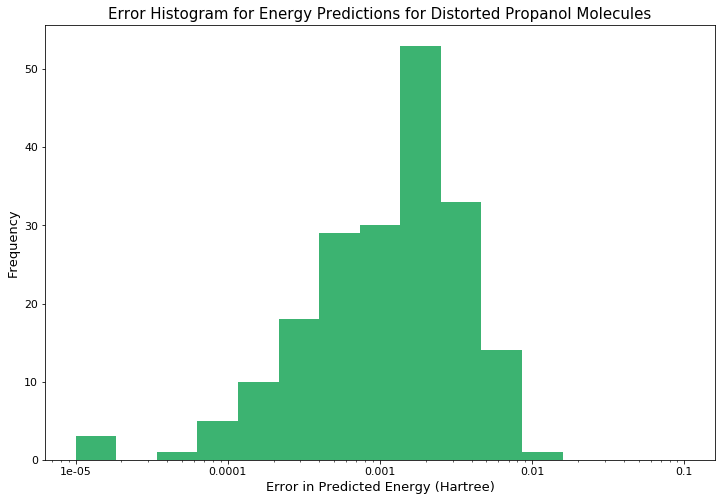

In [487]:
fig, ax = plt.subplots(figsize=(12,8))
errors = abs(predict_ens_custom_rescaled-test_ens_rescaled)/27.2114
logbins = np.logspace(-5,-1,16)
logticklabels = np.logspace(-5,-1,5)
plt.hist(errors, bins=logbins, color="mediumseagreen")
plt.xscale('log')
plt.xticks(logticklabels, labels=logticklabels)
plt.xlabel("Error in Predicted Energy (Hartree)")
plt.ylabel("Frequency")
plt.title("Error Histogram for Energy Predictions for Distorted Propanol Molecules")


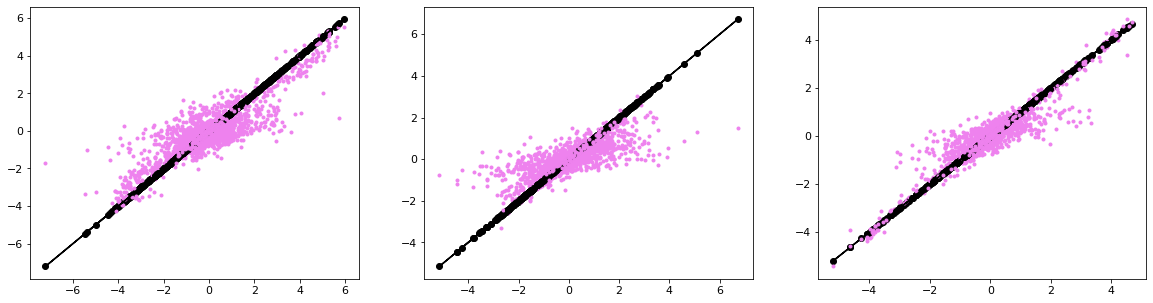

In [475]:

rescaled_test_frcs = test_frcs * ens_scaler.scale_
if plot_custom:
    rescaled_predict_frcs_custom =  predict_frcs_custom * ens_scaler.scale_
if plot_nll:
    rescaled_predict_frcs_nll = predict_frcs_nll * ens_scaler.scale_



fig, axs = plt.subplots(ncols=3, figsize=(20,5))
components = ["x", "y", "z"]

counts = [0,0,0]

for i in range(3):
    for j in range(rescaled_test_frcs.shape[1]):
        axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_test_frcs[:,j,i], "o-", c="k")
        if plot_custom:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], "o", label="custom", c="violet", ms=3)
            counts[i] +=1
#             try:
#                 print(i,j)
#                 m, b = np.polyfit(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], 1)
#                 r2 = np.corrcoef(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i])[0,1]
#                 print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
#             except:
#                 pass        
        if plot_nll:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_nll[:,j,i], "o", label="nll", c="lime", ms=5)
    #axs[i].legend()

# Save as script 

The following cell will save this notebook as a python script

In [1]:
!jupyter nbconvert --to script miniGAP.ipynb --output latest_miniGAP

[NbConvertApp] Converting notebook miniGAP.ipynb to script
[NbConvertApp] Writing 69372 bytes to latest_miniGAP.py
